In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
from rlway.pyosrd import OSRD
OSRD.use_cases

['c1',
 'c1_with_blocks',
 'c1y2',
 'c1y2_2trains',
 'c2x2',
 'c2xx2',
 'c2y11s',
 'c2y13s',
 'c2y1sy2sy1s',
 'c2y1y2',
 'c2y1y2y',
 'c2z2z2',
 'c3y1',
 'c3yy1yy3',
 'cvg_dvg',
 'point_switch',
 'station_capacity2',
 'straight_line']

[12:17:18,057] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[12:17:18,094] [INFO]              [FullInfra] parsing infra
[12:17:18,172] [INFO]              [FullInfra] adaptation to kotlin
[12:17:18,199] [INFO]              [FullInfra] loading signals
[12:17:18,204] [INFO]              [FullInfra] building blocks
[12:17:18,208] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[12:17:18,221] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.34
[12:17:18,273] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.35
[12:17:18,280] [INFO]  [StandaloneSimulationCommand] All simulations completed
[12:17:18,280] [INFO]  [StandaloneSimulationCommand] Saving results at: tmp/results.json
[12:17:18,510] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[12:17:18,539] [INFO]              [FullInfra] parsing infra
[12:17:18,601] [INFO]              [FullInfra] adaptation to

<Axes: xlabel='Time'>

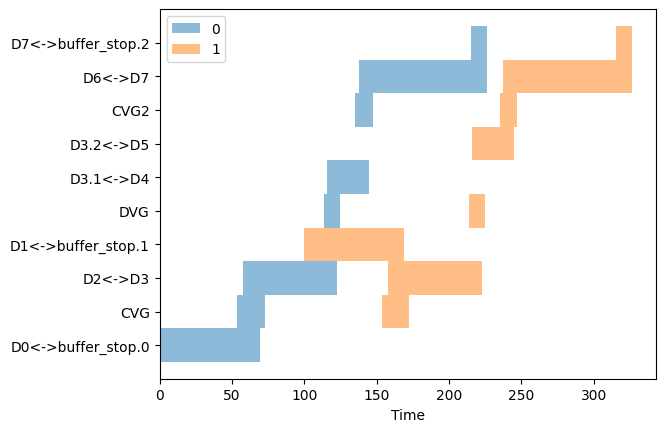

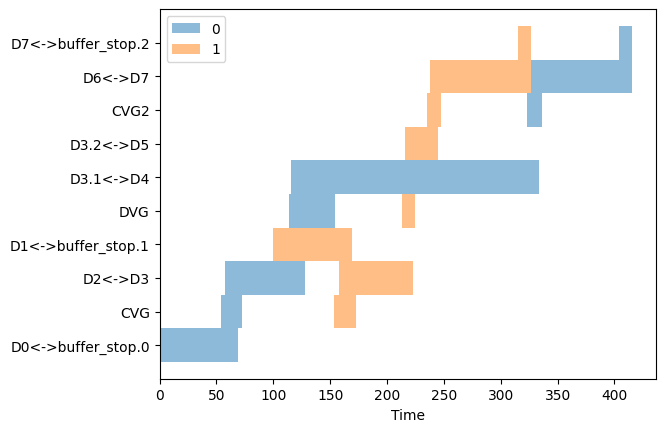

In [51]:
from rlway.schedules import schedule_from_osrd
from rlway.pyosrd.scenarii import c2y1y2y_2_trains_reorder

sim = c2y1y2y_2_trains_reorder.c2y1y2y_2_trains_reorder()

schedule_from_osrd(sim, eco_or_base='base').plot()

from rlway_cpagent.ortools_agent.ortools_agent import OrtoolsAgent

agent = OrtoolsAgent("cp_agent")
agent.set_schedules_from_osrd(sim)
agent.regulated_schedule.plot()

In [52]:
OSRD.scenarii


['c1_delay',
 'c1y2_2trains_conflict',
 'c1y2_2trains_no_conflict',
 'c2y11s_conflict_20_trains',
 'c2y1y2y_2_trains_no_conflict',
 'c2y1y2y_2_trains_reorder',
 'c2y1y2y_2_trains_same_order']

In [53]:
import importlib
from importlib.resources import files
import rlway.pyosrd.scenarii as scenarii
from rlway.pyosrd.scheduler_agent import SchedulerAgent
from rlway.schedules import Schedule
import rlway.schedules.weights as weights

import pandas as pd

In [54]:
def compute_metric(
        ref_schedule: Schedule,
        delayed_schedule: Schedule,
        weights: pd.DataFrame) -> float:
    trains = ref_schedule.trains
    starts = ref_schedule.starts
    delayed_starts = delayed_schedule.starts

    metric = 0.

    for train_idx, _ in enumerate(trains):
        for zone in ref_schedule.trajectory(train_idx):
            ref_time = int(starts.loc[zone][train_idx])
            delayed_time = int(delayed_starts.loc[zone][train_idx])
            weight = int(weights.loc[zone][train_idx])

            metric += (delayed_time - ref_time) * weight

    return metric


In [55]:
def launch_test_case(test_case, agent : SchedulerAgent, plot_all = False) -> pd.DataFrame:
    module = importlib.import_module(
                    f".{test_case}",
                    "rlway.pyosrd.test_cases"
                )
    function = getattr(module, test_case)
    sim = function()
    delayed_schedule = sim.delayed()

    agent.set_schedules_from_osrd(sim, "all_steps")

    delayed_schedule = schedule_from_osrd(delayed_schedule)
    ref_schedule = schedule_from_osrd(sim)
    regulated_schedule = agent.regulated_schedule
    if plot_all:
        display(ref_schedule.draw_graph())
        ref_schedule.plot()
        delayed_schedule.plot()
        agent.regulated_schedule.plot()


    data = pd.DataFrame({agent.name: [compute_metric(ref_schedule, regulated_schedule, weights.all_steps(sim))]},
                      index = [test_case])
    return data


def launch_all(test_cases, agent : SchedulerAgent) -> pd.DataFrame:
    data = []
    for test_case in test_cases:
            data.append(launch_test_case(test_case, agent))

    return pd.concat(data)

def launch_all_on_all(test_cases, agents) -> pd.DataFrame:
    data = []
    for agent in agents:
        data.append(launch_all(test_cases, agent))
    return pd.concat(data, axis=1)

In [56]:
from rlway_cpagent.ortools_agent.ortools_agent import OrtoolsAgent

agent1 = OrtoolsAgent("cp_agent")
agent1.allow_change_order = True

agent2 = OrtoolsAgent("cp_agent_no_change_order")
agent2.allow_change_order = False

data = launch_all_on_all(OSRD.scenarii, [agent1, agent2])

AttributeError: type object 'OSRD' has no attribute 'test_cases'

In [ ]:
print(data)

                              cp_agent  cp_agent_no_change_order
c1_delay                         420.0                     420.0
c1y2_2trains_conflict            104.0                     104.0
c1y2_2trains_no_conflict           0.0                       0.0
c2y11s_conflict_20_trains        507.0                     507.0
c2y1y2y_2_trains_no_conflict      30.0                      30.0
c2y1y2y_2_trains_reorder         566.0                     866.0
c2y1y2y_2_trains_same_order      419.0                     419.0


[12:15:49,019] [INFO]  [StandaloneSimulationCommand] Loading infra: tmp/infra.json
[12:15:49,046] [INFO]              [FullInfra] parsing infra
[12:15:49,100] [INFO]              [FullInfra] adaptation to kotlin
[12:15:49,120] [INFO]              [FullInfra] loading signals
[12:15:49,125] [INFO]              [FullInfra] building blocks
[12:15:49,129] [INFO]  [StandaloneSimulationCommand] Loading input: tmp/simulation.json
[12:15:49,144] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.32
[12:15:49,192] [DEBUG]             [Allowance] computing range n°1
[12:15:49,194] [DEBUG]             [Allowance]   computing section n°1
[12:15:49,194] [DEBUG]             [Allowance]   target time = 310.84094999999996
[12:15:49,194] [DEBUG]             [Allowance]     starting attempt 1
[12:15:49,196] [DEBUG]             [Allowance]     envelope time 518.958
[12:15:49,196] [DEBUG]             [Allowance]     starting attempt 2
[12:15:49,196] [DEBUG]             [Allo

,cp_agent
c1_delay,420.0


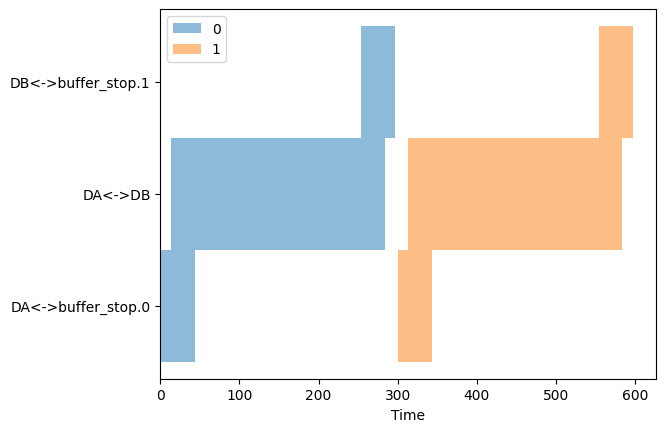

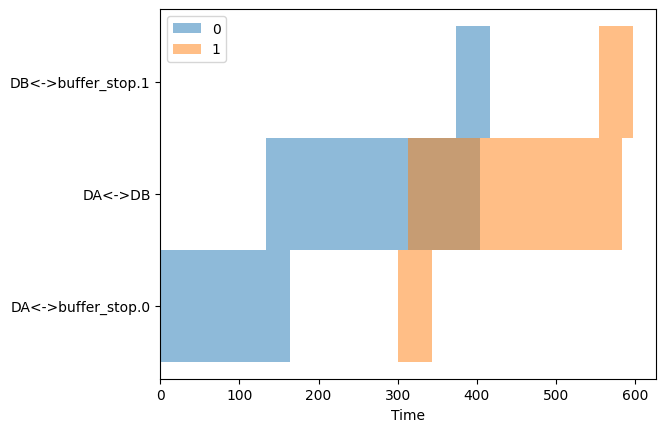

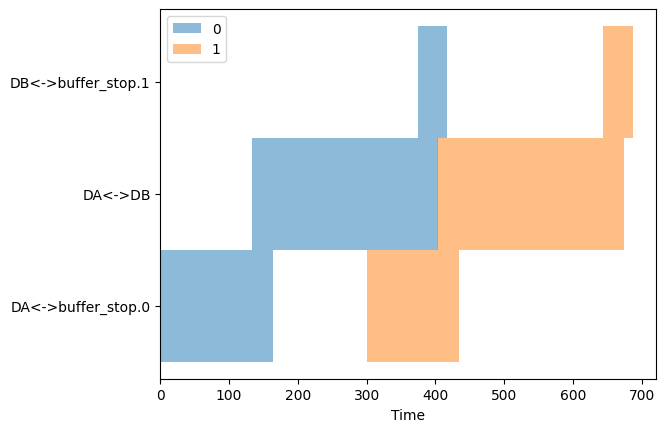

In [ ]:
launch_test_case("c1_delay", agent, True)
